In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob

plt.ion()   # interactive mode

In [ ]:
#from google.colab import drive
#drive.mount('drive')

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
!wget  https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -o hymenoptera_data.zip

--2022-11-12 01:56:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 65.9.86.120, 65.9.86.76, 65.9.86.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.9.86.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   139MB/s    in 0.3s    

2022-11-12 01:56:13 (139 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ant

In [ ]:
glob("*")

['hymenoptera_data.zip', 'hymenoptera_data', 'sample_data']

In [ ]:
data_dir = 'hymenoptera_data'

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'],
                                           batch_size=4,
                                           num_workers=1,
                                           shuffle=True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for imgs, labels in (train_loader):
    psum    += imgs.sum(axis        = [0, 2, 3])
    psum_sq += (imgs ** 2).sum(axis = [0, 2, 3])

count = len(train_loader.dataset) * 224 * 224
# mean and std
train_mean = psum / count
train_var  = (psum_sq / count) - (train_mean ** 2)
train_std  = torch.sqrt(train_var)

In [ ]:
train_mean
# [0.485, 0.456, 0.406]

tensor([0.5079, 0.4598, 0.3391])

In [ ]:
train_std
# [0.229, 0.224, 0.225]

tensor([0.2722, 0.2543, 0.2809])

In [ ]:
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
data_transforms = {
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['val']}

val_loader = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=4,
                                           num_workers=1,
                                           shuffle=True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for imgs, labels in (val_loader):
    psum    += imgs.sum(axis        = [0, 2, 3])
    psum_sq += (imgs ** 2).sum(axis = [0, 2, 3])

count = len(val_loader.dataset) * 224 * 224
# mean and std
val_mean = psum / count
val_var  = (psum_sq / count) - (val_mean ** 2)
val_std  = torch.sqrt(val_var)

In [ ]:
print(train_mean,train_std)

tensor([0.5079, 0.4598, 0.3391]) tensor([0.2722, 0.2543, 0.2809])


In [ ]:
print(val_mean,val_std)

tensor([0.5252, 0.4711, 0.3482]) tensor([0.2720, 0.2476, 0.2769])


In [ ]:
# Data augmentation and normalization for training to increase the size of the dataset
#and introduce variability in the dataset without actually collecting new data and data normalization to change
#the variables to a common scale
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
  # mean and SD of RGB colors
        transforms.Normalize(train_mean,train_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(val_mean,val_std)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
# dataset_sizes tells us how many data we have
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
for  data, label in dataloaders['val']:
  print(label)

tensor([1, 1, 0, 0])
tensor([1, 0, 1, 0])
tensor([0, 0, 1, 1])
tensor([0, 1, 1, 0])
tensor([1, 1, 1, 1])
tensor([0, 0, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 1])
tensor([1, 0, 0, 0])
tensor([1, 1, 1, 1])
tensor([1, 0, 0, 1])
tensor([0, 0, 1, 0])
tensor([1, 1, 1, 1])
tensor([0, 0, 1, 1])
tensor([1, 0, 1, 0])
tensor([0, 1, 0, 0])
tensor([1, 0, 1, 1])
tensor([1, 1, 0, 0])
tensor([1, 0, 0, 1])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 0, 0, 1])
tensor([1, 1, 0, 1])
tensor([1, 0, 1, 1])
tensor([0, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 0, 1, 1])
tensor([1, 0, 0, 1])
tensor([1, 0, 1, 1])
tensor([0, 1, 0, 0])
tensor([1, 0, 0, 0])
tensor([0, 0, 1, 1])
tensor([1, 0, 1, 1])
tensor([0, 1, 1, 1])
tensor([1, 0, 0, 0])
tensor([1, 1, 1, 1])
tensor([0, 1, 0, 1])
tensor([0, 0, 1, 0])
tensor([1])


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



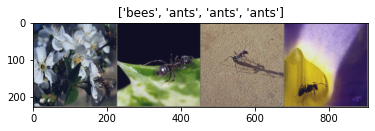

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      # ing:float=None, eps:float=1e-3):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode # enable backprogapation
            else:
                model.eval()   # Set model to evaluate mode # disable backpropagation

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    #loss = criterion(outputs, labels)

                    if isinstance(outputs, tuple):
                      # GoogleNet/inception_v3
                        loss = sum((criterion(o, labels) for o in outputs))
                    else:
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # backpropagation
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
class_names

['ants', 'bees']

In [ ]:
import torch
from torch.optim import Optimizer

# Compute norm depending on the shape of x
def unitwise_norm(x):
    if (len(torch.squeeze(x).shape)) <= 1: # Scalars, vectors
        axis = 0
        keepdims = False
    elif len(x.shape) in [2,3]: # Linear layers
        # Original code: IO
        # Pytorch: OI
        axis = 1
        keepdims = True
    elif len(x.shape) == 4: # Conv kernels
        # Original code: HWIO
        # Pytorch: OIHW
        axis = [1, 2, 3]
        keepdims = True
    else:
        raise ValueError(f'Got a parameter with len(shape) not in [1, 2, 3, 4]! {x}')

    return torch.sqrt(torch.sum(torch.square(x), axis=axis, keepdim=keepdims))

# Reference: https://github.com/vballoli/nfnets-pytorch/blob/main/nfnets/sgd_agc.py
# This is a copy of the pytorch SGD implementation
# enhanced with gradient clipping
class SGD_AGC(Optimizer):
    def __init__(self, named_params, lr:float, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, clipping:float=None, eps:float=1e-3):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        # Extra defaults
                        clipping=clipping,
                        eps=eps
                        )

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")

        # Put params in list so each one gets its own group
        params = named_params
        # for name, param in named_params:
        #    params.append({'params': param, 'name': name})

        super(SGD_AGC, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD_AGC, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            # Extra values for clipping
            clipping = group['clipping']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad

                # =========================
                # Gradient clipping
                if clipping is not None:
                    param_norm = torch.maximum(unitwise_norm(p), torch.tensor(eps).to(p.device))
                    grad_norm = unitwise_norm(d_p)
                    max_norm = param_norm * group['clipping']

                    trigger_mask = grad_norm > max_norm
                    clipped_grad = p.grad * (max_norm / torch.maximum(grad_norm, torch.tensor(1e-6).to(p.device)))
                    d_p = torch.where(trigger_mask, clipped_grad, d_p)
                # =========================

                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

In [ ]:
SGD_AGC

__main__.SGD_AGC

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
# the accuracy rate changes based if we are using pre-trained models or not.

# Experiment ResNet18 - original mean/std + StepLR
# Result: Accuracy = 70% if the model is not pre-trained on ResNet18

# Experiment ResNet18 - calculated mean/std + AGC + StepLR
# Result: Accuracy = 0.75

# Experiment ResNet50 - original mean/std + StepLR
# Result: When we used ResNet50, accuracy is 69%

# Experiment ResNet50 - calculated mean/std + AGC + StepLR
# Result: Accuracy is 0.718954

# Experiment ResNet101 - original mean/std + StepLR
# Result: When used ResNet101, accuracy decreased to 68%

# Experiment ResNet101 - calculated mean/std + StepLR
# Result: After modified means/std, the accuracy remained the same 67.9%

# Experiment ResNet101 - calculated mean/std + AGC + StepLR
# Result: Val Acc = 70% (0.699346)

# Dataset used may affect the model
model_ft = models.densenet121(pretrained=False)
num_ftrs = model_ft.classifier.in_features # model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be gneralized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = SGD_AGC(named_params = model_ft.parameters(), lr=1e-1, momentum=0.9, clipping=0.1, weight_decay=4e-5, nesterov=True)
# optimizer_ft = adamod.AdaMod(model_ft.parameters(), lr=1e-2, beta3=0.999, weight_decay=8e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

#The training loss indicates how well the model is fitting the training data,
#while the validation loss indicates how well the model fits new data.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


- lr_1 = 0.1
- lr_2 = 0.01
- lr_3 = 0.001
- lr_4 = 0.0001
- lr_5 = 0.00001
- lr_6 = 0.000001

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6803 Acc: 0.6025
val Loss: 0.6882 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.7591 Acc: 0.5738
val Loss: 0.6821 Acc: 0.6078

Epoch 2/9
----------
train Loss: 0.7427 Acc: 0.5451
val Loss: 0.6782 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.6956 Acc: 0.6270
val Loss: 1.1239 Acc: 0.6209

Epoch 4/9
----------
train Loss: 0.6876 Acc: 0.6148
val Loss: 0.6447 Acc: 0.6797

Epoch 5/9
----------
train Loss: 0.5964 Acc: 0.6885
val Loss: 0.6476 Acc: 0.6797

Epoch 6/9
----------
train Loss: 0.5994 Acc: 0.6516
val Loss: 0.6932 Acc: 0.6667

Epoch 7/9
----------
train Loss: 0.6086 Acc: 0.6885
val Loss: 0.6541 Acc: 0.6536

Epoch 8/9
----------
train Loss: 0.5776 Acc: 0.6967
val Loss: 0.6963 Acc: 0.6601

Epoch 9/9
----------
train Loss: 0.5850 Acc: 0.7090
val Loss: 0.6674 Acc: 0.6601

Training complete in 1m 25s
Best val Acc: 0.679739


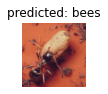

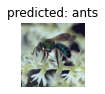

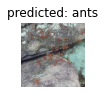

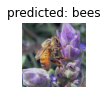

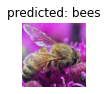

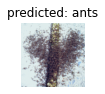

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
num_classes = 2
model_conv.classifier = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5515 Acc: 0.7008
val Loss: 0.2815 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6456 Acc: 0.7213
val Loss: 0.3795 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4515 Acc: 0.7910
val Loss: 0.4211 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.4095 Acc: 0.8197
val Loss: 0.2280 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3578 Acc: 0.8238
val Loss: 0.2071 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5254 Acc: 0.7582
val Loss: 0.2207 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3144 Acc: 0.8689
val Loss: 0.1974 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2890 Acc: 0.8893
val Loss: 0.2120 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3227 Acc: 0.8525
val Loss: 0.2557 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3449 Acc: 0.8770
val Loss: 0.2424 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2934 Acc: 0.8730
val Loss: 0.2014 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2712 Acc: 0.8975
val Loss: 0.2759 Acc: 0.8824

Ep

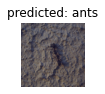

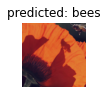

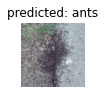

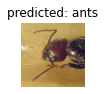

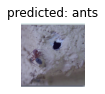

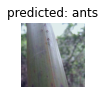

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [ ]:
import torchvision.models.quantization as models

# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1`. You can also use `weights=ResNet18_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


  0%|          | 0.00/11.2M [00:00<?, ?B/s]

In [ ]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [ ]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

TypeError: ignored